# **Loan Data Analysis and Modeling**

# *In this notebook, we will analyze the LendingClub loan dataset, preprocess the data, build regression and classification models, and make predictions on the test set.*

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For splitting data and model selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# For preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# For modeling
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.metrics import (r2_score, accuracy_score, f1_score, roc_auc_score,
                             roc_curve, confusion_matrix, classification_report)

# **1. Exploratory Data Analysis**
## **1.1 Load Data**


In [2]:
# Load training data
loan_df = pd.read_csv('/Volumes/FM/Subjects/Statistical Learning in Finance/Assignments/Assignment 1/lc_loan.csv')

# Load test data
loan_test_df = pd.read_csv('/Volumes/FM/Subjects/Statistical Learning in Finance/Assignments/Assignment 1/lc_loan_test.csv')

# Load submission template
submission_df = pd.read_csv('/Volumes/FM/Subjects/Statistical Learning in Finance/Assignments/Assignment 1/submission_test.csv')

# **1.2 Summary Statistics**

In [3]:
# Display summary statistics for key variables
key_vars = ['loan_amnt', 'int_rate', 'fico_range_high', 'annual_inc']
loan_df[key_vars].describe()

,loan_amnt,int_rate,fico_range_high,annual_inc
count,933160.000000,933160.000000,933160.000000,9.331600e+05
mean,12559.115559,0.119775,699.139987,7.412200e+04
std,8042.750083,0.039952,31.359739,6.938399e+04
min,500.000000,0.053200,664.000000,3.000000e+03
25%,6425.000000,0.089000,674.000000,4.400000e+04
50%,10000.000000,0.115300,694.000000,6.200000e+04
75%,16275.000000,0.143300,714.000000,9.000000e+04
max,40000.000000,0.309900,850.000000,9.573072e+06


# **1.3 Visualizations**
**Histograms**

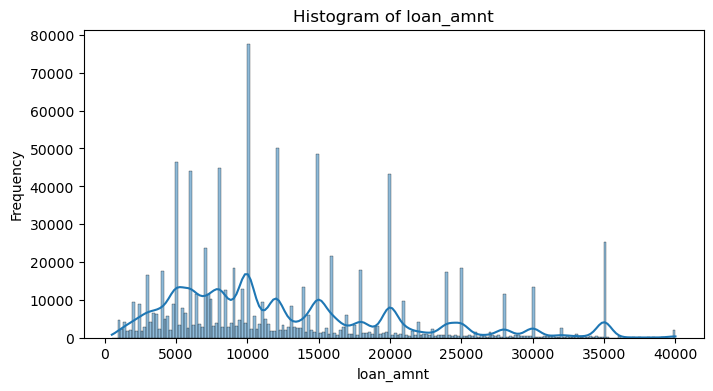

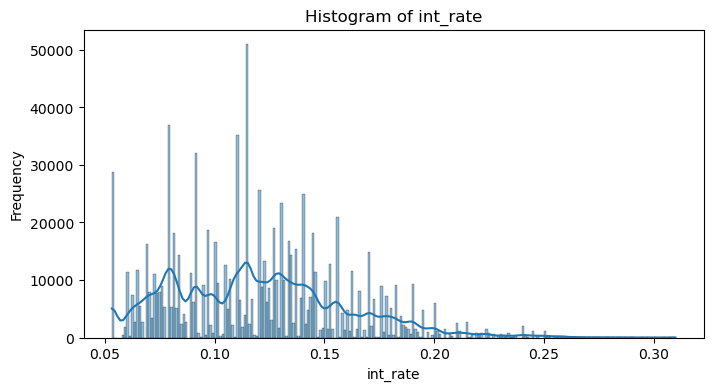

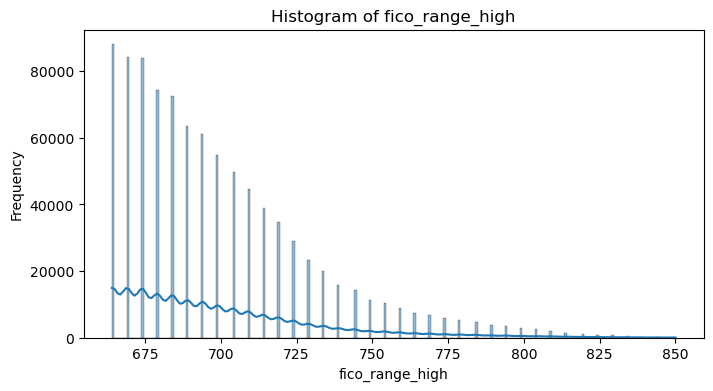

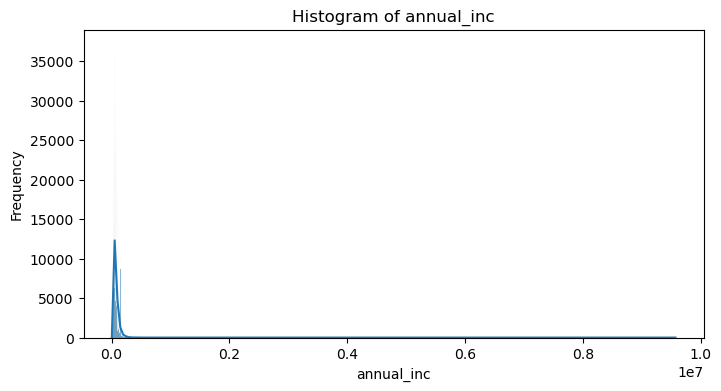

In [4]:
# Histograms for key variables
for var in key_vars:
    plt.figure(figsize=(8, 4))
    sns.histplot(loan_df[var].dropna(), kde=True)
    plt.title(f'Histogram of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.show()

**Scatter Plot**

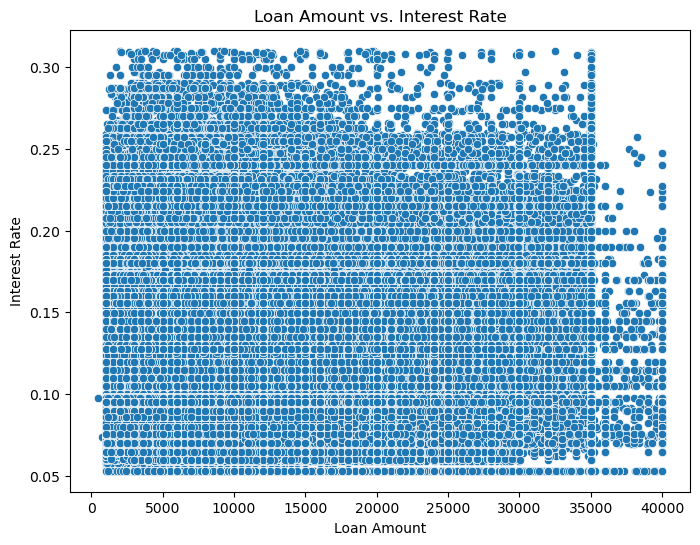

In [5]:
# Scatter plot of Loan Amount vs. Interest Rate
plt.figure(figsize=(8, 6))
sns.scatterplot(x='loan_amnt', y='int_rate', data=loan_df)
plt.title('Loan Amount vs. Interest Rate')
plt.xlabel('Loan Amount')
plt.ylabel('Interest Rate')
plt.show()

**Box Plot**

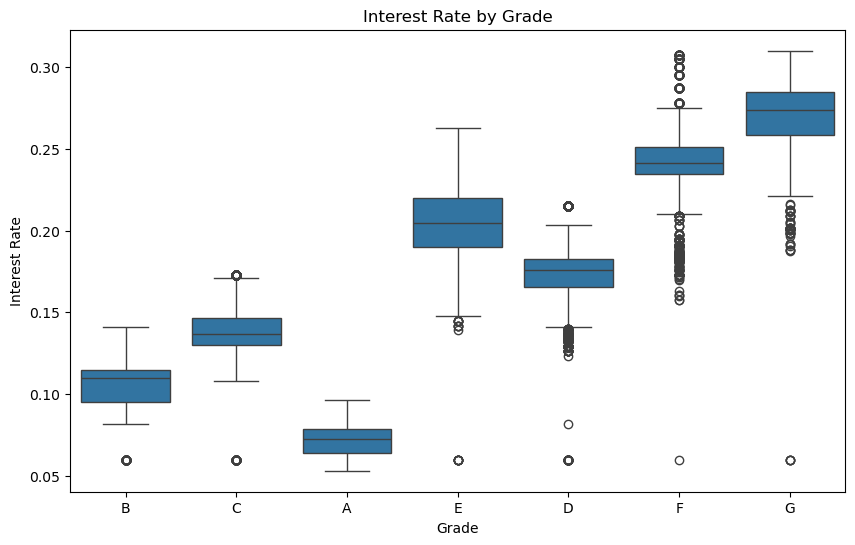

In [6]:
# Box plot of Interest Rate by Grade
plt.figure(figsize=(10, 6))
sns.boxplot(x='grade', y='int_rate', data=loan_df)
plt.title('Interest Rate by Grade')
plt.xlabel('Grade')
plt.ylabel('Interest Rate')
plt.show()

**Correlation Matrix**

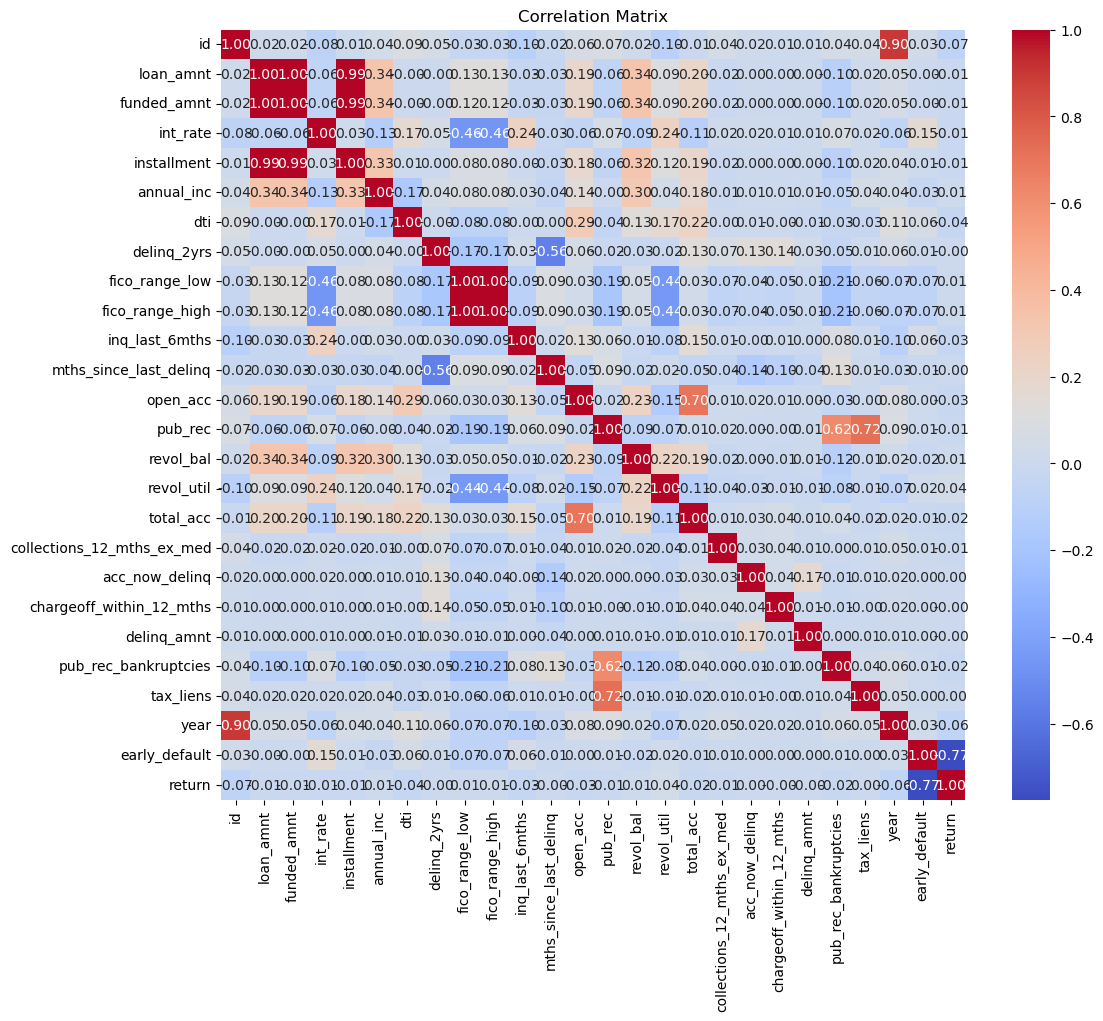

In [7]:
# Correlation matrix of numerical features
corr = loan_df.select_dtypes(include=['float64', 'int64']).corr()

# Heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# **2. Data Preprocessing**
## **2.1 Sampling**


In [8]:
# Separate features and target variables for regression and classification
X = loan_df.drop(['return', 'early_default'], axis=1)

# Targets
y_reg = loan_df['return']          # Regression target
y_clf = loan_df['early_default']   # Classification target

# Split data into training and validation sets for regression
X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42)

# Split data into training and validation sets for classification
X_train_clf, X_val_clf, y_train_clf, y_val_clf = train_test_split(
    X, y_clf, test_size=0.2, random_state=42)

## **2.2 Handling Missing Values**

In [9]:
# Check for missing values
missing_values = loan_df.isnull().sum()
print("Columns with missing values:\n", missing_values[missing_values > 0])

Columns with missing values:
 emp_length                 58768
mths_since_last_delinq    464293
dtype: int64


## 2.3 Feature Engineering

Identify Numerical and Categorical Columns

In [10]:
# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

Create Interaction and Nonlinear Terms

In [11]:

# Create interaction and nonlinear terms for both training and validation sets
X_train_clf['int_rate_loan_amnt'] = X_train_clf['int_rate'] * X_train_clf['loan_amnt']
X_train_clf['annual_inc_squared'] = X_train_clf['annual_inc'] ** 2

X_val_clf['int_rate_loan_amnt'] = X_val_clf['int_rate'] * X_val_clf['loan_amnt']
X_val_clf['annual_inc_squared'] = X_val_clf['annual_inc'] ** 2


Scaling and Encoding

In [12]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

Combine Preprocessing Steps

In [13]:
# Combine numerical and categorical transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# **3. Model Building**
## **3.1 Linear Regression Model**



In [14]:
# Pipeline for linear regression
regression_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the model
regression_pipeline.fit(X_train_reg, y_train_reg)

# Predictions
y_pred_train_reg = regression_pipeline.predict(X_train_reg)
y_pred_val_reg = regression_pipeline.predict(X_val_reg)

# Report R-squared scores
train_r2 = r2_score(y_train_reg, y_pred_train_reg)
val_r2 = r2_score(y_val_reg, y_pred_val_reg)

print(f'Training R-squared: {train_r2:.4f}')
print(f'Validation R-squared: {val_r2:.4f}')

Training R-squared: 0.7531
Validation R-squared: 0.7523


## **3.2 Regularized Regression Models**
**Lasso Regression**

In [15]:
# Pipeline for Lasso regression
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso())
])

# Hyperparameter grid
lasso_param_grid = {
    'regressor__alpha': np.logspace(-4, 0, 10)
}

# Grid search with cross-validation
lasso_search = GridSearchCV(lasso_pipeline, param_grid=lasso_param_grid, cv=5,
                            scoring='r2', n_jobs=-1)

# Fit the model
lasso_search.fit(X_train_reg, y_train_reg)

# Best model
best_lasso = lasso_search.best_estimator_

# Predictions
y_pred_train_lasso = best_lasso.predict(X_train_reg)
y_pred_val_lasso = best_lasso.predict(X_val_reg)

# Report R-squared scores
train_r2_lasso = r2_score(y_train_reg, y_pred_train_lasso)
val_r2_lasso = r2_score(y_val_reg, y_pred_val_lasso)

print(f'Lasso Training R-squared: {train_r2_lasso:.4f}')
print(f'Lasso Validation R-squared: {val_r2_lasso:.4f}')

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Lasso Training R-squared: 0.7519
Lasso Validation R-squared: 0.7523


Ridge Regression

In [17]:
# Pipeline for Ridge regression
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

# Hyperparameter grid
ridge_param_grid = {
    'regressor__alpha': np.logspace(-4, 0, 10)
}

# Grid search with cross-validation
ridge_search = GridSearchCV(ridge_pipeline, param_grid=ridge_param_grid, cv=5,
                            scoring='r2', n_jobs=-1)

# Fit the model
ridge_search.fit(X_train_reg, y_train_reg)

# Best model
best_ridge = ridge_search.best_estimator_

# Predictions
y_pred_train_ridge = best_ridge.predict(X_train_reg)
y_pred_val_ridge = best_ridge.predict(X_val_reg)

# Report R-squared scores
train_r2_ridge = r2_score(y_train_reg, y_pred_train_ridge)
val_r2_ridge = r2_score(y_val_reg, y_pred_val_ridge)

print(f'Ridge Training R-squared: {train_r2_ridge:.4f}')
print(f'Ridge Validation R-squared: {val_r2_ridge:.4f}')

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Ridge Training R-squared: 0.7531
Ridge Validation R-squared: 0.7524


Elastic Net Regression

In [18]:
# Pipeline for Elastic Net regression
elasticnet_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet())
])

# Adjusted hyperparameter grid
elasticnet_param_grid = {
    'regressor__alpha': np.logspace(-4, -2, 3),  # Fewer values
    'regressor__l1_ratio': [0.1, 0.5]
}

# Using Randomized Search
elasticnet_search = RandomizedSearchCV(elasticnet_pipeline, param_distributions=elasticnet_param_grid,
                                       n_iter=5, cv=3, scoring='r2', n_jobs=2, verbose=1)

# Fit the model on a smaller sample if necessary
X_sample = X_train_reg.sample(frac=0.1, random_state=42)  # Use 10% of the data
y_sample = y_train_reg.loc[X_sample.index]
elasticnet_search.fit(X_sample, y_sample)

# Best model
best_elasticnet = elasticnet_search.best_estimator_

# Predictions
y_pred_train_enet = best_elasticnet.predict(X_train_reg)
y_pred_val_enet = best_elasticnet.predict(X_val_reg)

# Report R-squared scores
train_r2_enet = r2_score(y_train_reg, y_pred_train_enet)
val_r2_enet = r2_score(y_val_reg, y_pred_val_enet)

print(f'ElasticNet Training R-squared: {train_r2_enet:.4f}')
print(f'ElasticNet Validation R-squared: {val_r2_enet:.4f}')

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.31011419453511735, tolerance: 0.3068663659952295
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.32196670761277346, tolerance: 0.3020406961271953
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.30788098650714346, tolerance: 0.3057453635907547
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate

ElasticNet Training R-squared: 0.7517
ElasticNet Validation R-squared: 0.7520


## **3.3 Logistic Regression**

In [19]:
# Pipeline for logistic regression
clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Fit the model
clf_pipeline.fit(X_train_clf, y_train_clf)

# Predictions (probabilities)
y_proba_train = clf_pipeline.predict_proba(X_train_clf)[:, 1]
y_proba_val = clf_pipeline.predict_proba(X_val_clf)[:, 1]

Threshold Selection

In [20]:
# Calculate F1 scores for different thresholds
fpr, tpr, thresholds = roc_curve(y_val_clf, y_proba_val)
f1_scores = []

for thresh in thresholds:
    y_pred_thresh = (y_proba_val >= thresh).astype(int)
    f1 = f1_score(y_val_clf, y_pred_thresh)
    f1_scores.append(f1)

# Optimal threshold based on max F1 score
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
max_f1 = f1_scores[optimal_idx]

print(f'Optimal Threshold: {optimal_threshold:.4f}')
print(f'Maximum F1 Score: {max_f1:.4f}')

Optimal Threshold: 0.2596
Maximum F1 Score: 0.5395


Evaluate Model Performance

In [22]:
# Predictions with optimal threshold
y_pred_train = (y_proba_train >= optimal_threshold).astype(int)
y_pred_val = (y_proba_val >= optimal_threshold).astype(int)

# Training metrics
train_accuracy = accuracy_score(y_train_clf, y_pred_train)
train_f1 = f1_score(y_train_clf, y_pred_train)
train_auc = roc_auc_score(y_train_clf, y_proba_train)

# Validation metrics
val_accuracy = accuracy_score(y_val_clf, y_pred_val)
val_f1 = f1_score(y_val_clf, y_pred_val)
val_auc = roc_auc_score(y_val_clf, y_proba_val)

print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Training F1 Score: {train_f1:.4f}')
print(f'Training AUC Score: {train_auc:.4f}\n')

print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation F1 Score: {val_f1:.4f}')
print(f'Validation AUC Score: {val_auc:.4f}')

Training Accuracy: 0.9161
Training F1 Score: 0.5412
Training AUC Score: 0.9620

Validation Accuracy: 0.9167
Validation F1 Score: 0.5395
Validation AUC Score: 0.9603


# **4. Predicting on the Test Set**
## **4.1 Prepare Test Data**

In [23]:
# Create interaction and nonlinear terms in the test set
loan_test_df['int_rate_loan_amnt'] = loan_test_df['int_rate'] * loan_test_df['loan_amnt']
loan_test_df['annual_inc_squared'] = loan_test_df['annual_inc'] ** 2

# Separate features for regression and classification
X_test_reg = loan_test_df.copy()
X_test_clf = loan_test_df.copy()

## **4.2 Make Predictions**

Regression Predictions

In [24]:
# Ensure that the columns match between training and testing sets
X_test_reg = X_test_reg.reindex(columns=X_train_reg.columns, fill_value=0)

# Now make predictions with the fixed test set
y_pred_test_reg = best_elasticnet.predict(X_test_reg)


Classification Predictions

In [25]:
# Ensure that the columns match between training and testing sets
X_test_clf = X_test_clf.reindex(columns=X_train_clf.columns, fill_value=0)

# Now make predictions with the fixed test set
y_proba_test_clf = clf_pipeline.predict_proba(X_test_clf)[:, 1]

# Apply optimal threshold to get final predictions
y_pred_test_clf = (y_proba_test_clf >= optimal_threshold).astype(int)


## **4.3 Prepare Submission File**

In [26]:
# Update the submission DataFrame with predictions
submission_df['early_default'] = y_pred_test_clf
submission_df['return'] = y_pred_test_reg

# Ensure that the 'id' column is properly aligned
submission_df = submission_df[['id', 'early_default', 'return']]

# Save the submission file
submission_df.to_csv('submission_test.csv', index=False)

print("Predictions saved to submission_test.csv.")

Predictions saved to submission_test.csv.
